In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Simulating Time Series Data

We will very naively simulate time series data below

In [27]:
SEED = 99

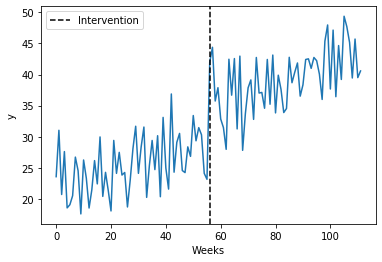

In [159]:
np.random.seed(SEED)
N = 112
ARMA = sm.tsa.ArmaProcess(ar=[1, 0.5], ma=[1])
intervention_effect = np.repeat([0,5], N/2)
seasonal_effect = np.tile([4, 4.5, 2.75, 2, 1, -3, -2], N//7)
trend = .15
metric = (20 + ARMA.generate_sample(nsample=N)*3) + intervention_effect + seasonal_effect + np.arange(N)*trend

plt.plot( metric )
plt.ylabel("y")
plt.xlabel("Weeks")
plt.axvline(56, ls="--", color="k", label="Intervention")
plt.legend()

# Scenario

Your company launched an intervention at week 56 to all customers. Your goal is to identify if the intervention had an impact.

The approach to this is simple - simply do some feature engineering to make some variables representing:
 * A pre-existing trend, represented via an array [1:N], where N is the length of the time series. So if the length of the time series is 16, the trend=[0,1,2,...,15]
 * A seasonality component, such as day of week, or month, in dummy or factor form. This could also be encoded in a time series model such as a sarima model instead
 * An intervention dummy variable, where 0 represents the pre-intervention period and 1 represents the post intervention period
 * A trend variable, where 0 represents the pre-intervention period and X=[1:n], where n represents the length of the post-intervention period
 * The appropriate moving average or autoregressive component for the time series if there's autocorrelation
 
Technically you dont need to include all of the time series components if you have strong beliefs that they do not exist in your data. Models themselves are just assumptions, after all. We'll start off simple and ignore the AR/MA time series components

In [160]:
df = pd.DataFrame({
    "y":metric,
    "t":np.arange(len(metric)),
    "dow": np.tile(range(7), 16).astype(str),
    "intervention":np.repeat([0,1],56),
    "trend": np.r_[np.zeros(N//2), np.arange(N//2)],
})

pd.concat((df.head(10), df.tail(10)))


,y,t,dow,intervention,trend
0,23.572923,0,0,0,0.0
1,31.035203,1,1,0,0.0
2,20.707184,2,2,0,0.0
3,27.610844,3,3,0,0.0
4,18.555713,4,4,0,0.0
5,19.065051,5,5,0,0.0
6,20.508016,6,6,0,0.0
7,26.722932,7,0,0,0.0
8,24.524326,8,1,0,0.0
9,17.584324,9,2,0,0.0


In [161]:
model1 = smf.ols("y ~ t + dow + intervention + trend",data=df).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     61.89
Date:                Tue, 13 Jul 2021   Prob (F-statistic):           2.53e-37
Time:                        09:31:21   Log-Likelihood:                -292.37
No. Observations:                 112   AIC:                             604.7
Df Residuals:                     102   BIC:                             631.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       25.0439      1.185     21.125      0.000      22.693      27.395
dow[T.1]        -0.8296      1.220     -0.680      0.498      -3.249       1.590
dow[T.2]        -2.6888      1.220     -2.203      0.030      -5.109      -0.268
dow[T.3]        -2.8985      1.221     -2.374      0.019      -5.321      -0.476
dow[T.4]        -2.7547      1.222     -2.254      0.026      -5.179      -0.330
dow[T.5]        -6.8368      1.224     -5.586      0.000      -9.264      -4.409
dow[T.6]        -6.9952      1.226     -5.707      0.000      -9.426      -4.564
t                0.1330      0.029      4.644      0.000       0.076       0.190
intervention     5.6410      1.312      4.301      0.000       3.039       8.243
trend            0.0305      0.040      0.757      0.451      -0.049       0.111
==============================================================================
Omnibus:                        1.165   Durbin-Watson:                   2.992
Prob(Omnibus):                  0.558   Jarque-Bera (JB):                1.138
Skew:                          -0.116   Prob(JB):                        0.566
Kurtosis:                       2.564   Cond. No.                         502.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Great news, the intervention variable correctly identifies that there's an intervention effect. The bad news is that the 95% confidence interval is very wide.

Looking at the durbin watson statistic, there may be some evidence of autocorrelation. We'll test for this using the Ljung-Box statistic

In [162]:
_, pval = sm.stats.diagnostic.acorr_ljungbox(model1.resid, lags=range(1,12+1))
pd.DataFrame({"lag":range(1,12+1),"pval":pval},columns=["lag", "pval"]).set_index("lag")

,pval
lag,
1,9.953269e-08
2,8.115103e-09
3,2.070308e-08
4,7.100382e-08
5,1.936095e-07
6,9.629034e-08
7,1.656582e-08
8,1.803869e-09
9,1.946933e-09


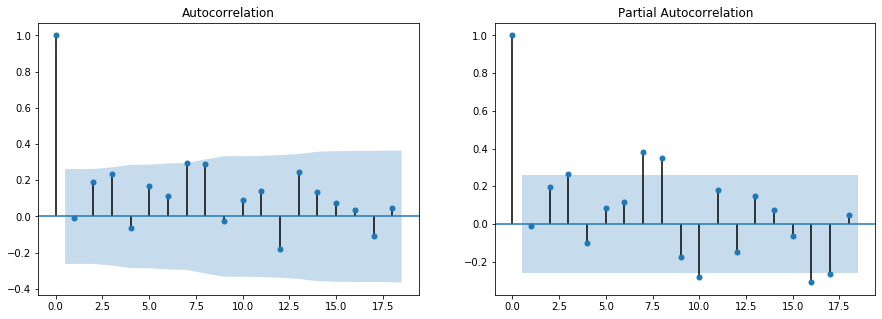

In [163]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
sm.tsa.graphics.plot_acf(df.y.values[:56],ax=ax[0])
sm.tsa.graphics.plot_pacf(df.y.values[:56],ax=ax[1]);

I wont go into how to identify the right AR/MA components to use, but I will show you what happens when you identify them correctly

In [164]:
y = df.y
X = pd.concat((df.drop(["y","dow"],axis=1), pd.get_dummies(df.dow,drop_first=True)),axis=1)

In [165]:
model2 = sm.tsa.ARIMA(
    endog=y,
    order=[1,0,0],
    exog=X

).fit()

model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  112
Model:                     ARMA(1, 0)   Log Likelihood                -276.572
Method:                       css-mle   S.D. of innovations              2.855
Date:                Tue, 13 Jul 2021   AIC                            577.144
Time:                        09:31:23   BIC                            609.766
Sample:                             0   HQIC                           590.380
                                                                              
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           25.0230      0.929     26.931      0.000      23.202      26.844
t                0.1347      0.016      8.367      0.000       0.103       0.166
intervention     5.4667      0.740      7.391      0.000       4.017       6.916
trend            0.0312      0.023      1.385      0.169      -0.013       0.075
1               -0.8163      1.397     -0.584      0.560      -3.555       1.922
2               -2.6823      1.018     -2.636      0.010      -4.677      -0.688
3               -2.8977      1.186     -2.443      0.016      -5.222      -0.573
4               -2.7418      1.182     -2.321      0.022      -5.058      -0.426
5               -6.8577      1.027     -6.679      0.000      -8.870      -4.845
6               -6.9523      1.386     -5.017      0.000      -9.668      -4.236
ar.L1.y         -0.4939      0.081     -6.064      0.000      -0.654      -0.334
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.0248           +0.0000j            2.0248            0.5000
-----------------------------------------------------------------------------
"""

Now the intervention effect is both closer to the true estimate, and has a more narrow confidence interval